#Librerias

Son las librerias necesarias para la ejecución del codigo, en donde se desarrolla el administrador de portafolio de inversión.


In [1]:
#Ejecutar pip en la primera ejecución
!pip install yahoo-fin --upgrade
!pip install requests_html

from yahoo_fin import stock_info
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random
import tensorflow as tf
from keras.layers import Dense,Dropout,Conv1D,Input,Flatten,MaxPooling1D
from keras.models import Sequential,load_model
from keras.optimizers import adam_v2
from sklearn.metrics import accuracy_score
%run '/content/drive/MyDrive/Escrito/Codigo/Portafolio/Datos.ipynb' import *
%run '/content/drive/MyDrive/Escrito/Codigo/Portafolio/Portafolio.ipynb' import *
%run '/content/drive/MyDrive/Escrito/Codigo/Portafolio/Trading_ML.ipynb' import * 

#Definición de Variables de inversión

Lista de las emisoras a extraer información, así como las fechas iniciales y finales de la información requerida y administración del portafolio.

Se inicia con un monto inicial del inversión y las fechas de simulación.

In [2]:
fecha_inicio='2020-01-01'
fecha_final="2021-05-30"

fecha_ini=dt.datetime(2020,1,1)
fecha_fin=dt.datetime(2021,10,14)
hoy=dt.date.today()

#Carga empresas a evaluar
emp= pd.read_csv('/content/drive/MyDrive/Escrito/Codigo/Portafolio/Emisoras.csv',encoding='latin-1')   #Actualizar Ruta del archivo
emp.head()

#Definición de emisoras 
lista_emp= np.array(emp['Emisora'])

In [3]:
#Tamaño del portafolio
n=5
#Monto a invertir
mto_invertir=100000
#Monto invertido
mto_invertido=0
#Fechas de simulación
fecha_inicio_sim=fecha_fin+dt.timedelta(days=1)
fecha_fin_sim=fecha_inicio_sim

In [4]:
base= preciost(lista_emp,fecha_ini,hoy)
base.index.name='Date'
base.to_csv('/content/precios.csv')

#Administrador del Portafolio de inversión

Función que junta cada uno de los distintos procesos que permiten la creación, optimización e identificador de momentos de inversión para incrementar el rendimiento de inversión.

In [5]:
def administrador(mto_invertir=100000,mto_invertido=0,tam_port=5,emisoras=lista_emp,fecha_ini=dt.datetime(2020,1,1),fecha_fin=dt.datetime(2021,5,30),tiempo=10,ventana=False,tam_vent=20):
  dias=1
  inversion=[mto_invertir]
  periodo=[fecha_fin]
  rendimiento=[0]
  rendimiento_portafolio=[]
  riesgo=[]
  sharpe=[]
  titulos=0
  print('Cargando Datos...')
  base=preciost(emisoras,fecha_ini,fecha_fin)
  print('Datos Listos!')
  path='/content/precios.csv'
  while dias<=tiempo:#fecha_fin_sim <dt.datetime(2021,6,15):
    #Fechas de simulación
    fecha_fin_sim=fecha_fin+dt.timedelta(days=dias)
    if fecha_fin_sim.isoweekday() >5:
      dias+=1
      continue
    periodo.append(fecha_fin_sim)
    fecha_inicio_sim=fecha_fin-dt.timedelta(days=100)
    #Creación del portafolio de inversión
    if mto_invertido==0:
      print(f"Creando un portafolio de inversión con {tam_port} emisoras")
      print('Actualizando Precios...')
      precio=precios1(path,emisoras,fecha_ini,fecha_fin+dt.timedelta(days=dias-1))
      print('Datos listos!')
      #Extracción de datos y rendimientos
      #Calculo de rendimientos de los precios obtenidos
      rend=rendimientos(precio)
      #Rendimiento esperado y riesgo de cada acción
      metricasRV(rend)
      #Filtro de emisoras
      if ventana:
        filtro=top(rend.tail(tam_vent),tam_port)
      else:
        filtro=top(rend,tam_port)
      #Optimización del Portafolio
      pesos=optimizacion(rend[filtro])      
      print('Portafolio de inversión creado')
      print(list(zip(filtro,pesos)))
      plt.figure(figsize=(7,7))
      plt.barh(filtro,pesos)
      plt.xlabel('Peso de participación')
      plt.ylabel('Emisora')
      plt.title('Distribución del Portafolio')
      #plt.xlabel('Investment Days')
      #plt.ylabel('Companies')
      #plt.title('Investment Distribution')
      plt.show()
      #Modelo de Aprendizaje
      print('Entrenando Modelo...')
      decision_CNN(path,filtro,pesos,fecha_ini,fecha_fin+dt.timedelta(days=dias-1))
      momento,valor_portafolio=eva_red(path,'decision_cnn.h5',filtro,pesos,fecha_inicio_sim,fecha_fin+dt.timedelta(days=dias-1))
      if momento==0:
        print('Tendencia bajista no se invierte en el portafolio de inversión')
        dias+=1
        inversion.append(mto_invertir)
        rendi=((inversion[-1]-inversion[0])/inversion[0])-1
        rendimiento.append(rendi)
        rendimiento_portafolio.append(rend_port(rend[filtro],pesos))
        riesgo.append(ries_port(rend[filtro],pesos))
        sharpe.append(sharper(rend[filtro],pesos))
        continue
      titulos=mto_invertir/valor_portafolio
      mto_invertido=mto_invertir
      mto_invertir=0
      inversion.append(mto_invertido)
      rendi=(abs(inversion[-1]-inversion[0])/inversion[0])-1
      rendimiento.append(rendi)
      rendimiento_portafolio.append(rend_port(rend[filtro],pesos))
      riesgo.append(ries_port(rend[filtro],pesos))
      sharpe.append(sharper(rend[filtro],pesos))
      print('Tendencia alcista se invierte en el portafolio de inversión')
    #Evaluación del periodo t+1
    print('Evaluación')
    momento,valor_portafolio=eva_red(path,'decision_cnn.h5',filtro,pesos,fecha_inicio_sim,fecha_fin_sim)
    inversion.append(valor_portafolio*titulos)
    if momento==0:
      print('Tendencia bajista se actualiza el portafolio de inversión')
      mto_invertido=0
      mto_invertir=valor_portafolio*titulos
    print(f'Días de Inversión {dias} \tInversión actual ${valor_portafolio*titulos}')
    dias+=1
  return inversion,periodo, list(zip(filtro,pesos)),list(zip(rendimiento_portafolio,riesgo,sharpe)),rendimiento


Ejecución del Administrador del Portafolio de Inversión, a traves de una lista de ventanas de tiempo especificada.

	 Portafolio de Inversión Total
Cargando Datos...
Datos Listos!
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('PAPPEL.MX', 0.22096648119399584), ('FCX.MX', 0.42209138582430633), ('TSLA.MX', 0.12945512662530867), ('PINS.MX', 0.11424526813904119), ('MRNA.MX', 0.11324173821734806)]


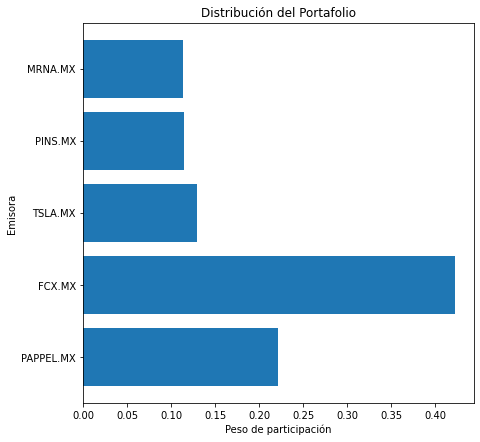

Entrenando Modelo...
Tendencia alcista se invierte en el portafolio de inversión
Evaluación
Días de Inversión 1 	Inversión actual $101090.78544350297
Evaluación
Tendencia bajista se actualiza el portafolio de inversión
Días de Inversión 2 	Inversión actual $99419.6178605207
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('PAPPEL.MX', 0.21710018798704722), ('FCX.MX', 0.43155569701914825), ('TSLA.MX', 0.12800299788397385), ('PINS.MX', 0.1119371726258429), ('MRNA.MX', 0.11140394448398777)]


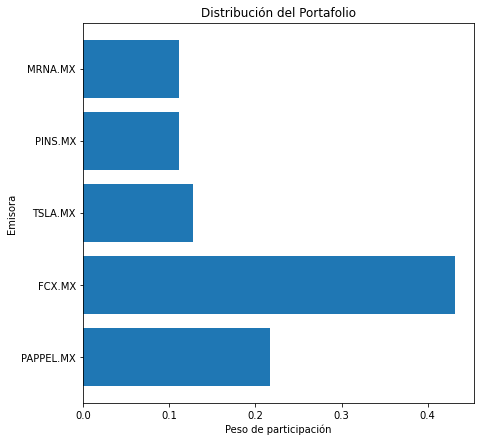

Entrenando Modelo...
Tendencia alcista se invierte en el portafolio de inversión
Evaluación
Tendencia bajista se actualiza el portafolio de inversión
Días de Inversión 3 	Inversión actual $97058.81878314889
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('PAPPEL.MX', 0.22115051354850657), ('FCX.MX', 0.4275079797725624), ('MRNA.MX', 0.11879817744779202), ('TSLA.MX', 0.12128617026795459), ('PINS.MX', 0.11125715896318432)]


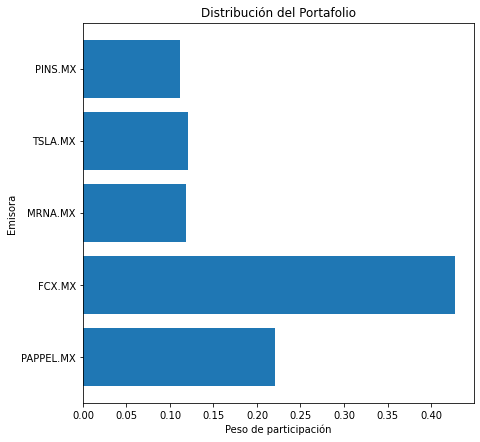

Entrenando Modelo...
Tendencia bajista no se invierte en el portafolio de inversión
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('PAPPEL.MX', 0.22317661327979846), ('FCX.MX', 0.42434005251607143), ('MRNA.MX', 0.12690445068557013), ('PINS.MX', 0.11178276286524945), ('TSLA.MX', 0.11379612065331059)]


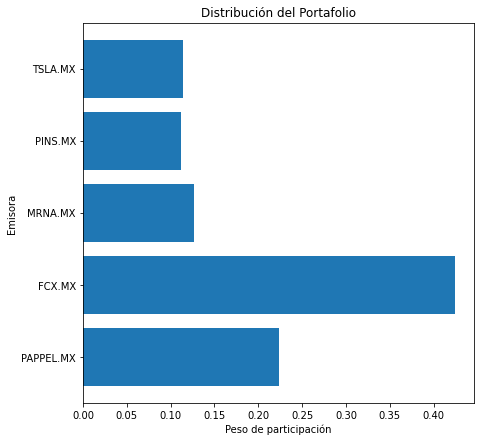

Entrenando Modelo...
Tendencia alcista se invierte en el portafolio de inversión
Evaluación
Días de Inversión 5 	Inversión actual $97058.81878314889
Evaluación
Tendencia bajista se actualiza el portafolio de inversión
Días de Inversión 8 	Inversión actual $97500.46226333918
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('PAPPEL.MX', 0.22062519190120103), ('MRNA.MX', 0.1399249139097152), ('FCX.MX', 0.4087963604305134), ('PINS.MX', 0.11295758250268682), ('TSLA.MX', 0.1176959512558835)]


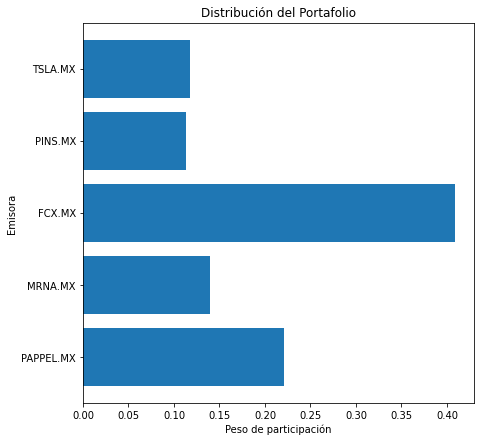

Entrenando Modelo...
Tendencia bajista no se invierte en el portafolio de inversión
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('PAPPEL.MX', 0.22232873137392437), ('MRNA.MX', 0.14352579272624183), ('FCX.MX', 0.44520748073999966), ('PINS.MX', 0.1351272508767031), ('SPCE.MX', 0.05381074428313104)]


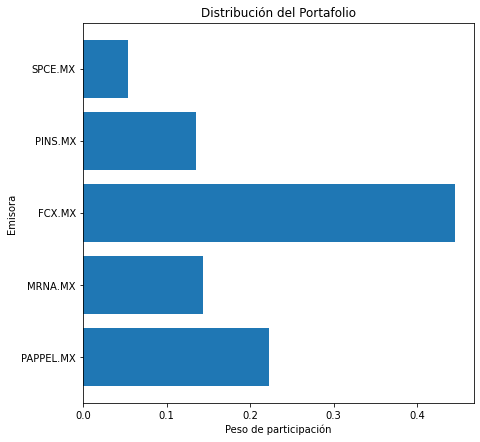

Entrenando Modelo...
Tendencia alcista se invierte en el portafolio de inversión
Evaluación
Días de Inversión 10 	Inversión actual $97486.30795009738
Evaluación
Días de Inversión 11 	Inversión actual $98718.14010578695
Evaluación
Días de Inversión 12 	Inversión actual $98718.14010578695
Evaluación
Días de Inversión 15 	Inversión actual $94776.3467450565
Evaluación
Días de Inversión 16 	Inversión actual $94976.75240046054
Evaluación
Días de Inversión 17 	Inversión actual $97656.04680189604
Evaluación
Días de Inversión 18 	Inversión actual $97113.34488766995
Evaluación
Días de Inversión 19 	Inversión actual $97113.34488766995
Evaluación
Días de Inversión 22 	Inversión actual $103312.70607690014
Evaluación
Días de Inversión 23 	Inversión actual $101906.0864847685
Evaluación
Días de Inversión 24 	Inversión actual $102370.0218813931
Evaluación
Días de Inversión 25 	Inversión actual $106112.47908287396
Evaluación
Días de Inversión 26 	Inversión actual $106112.47908287396
Evaluación
Días de I

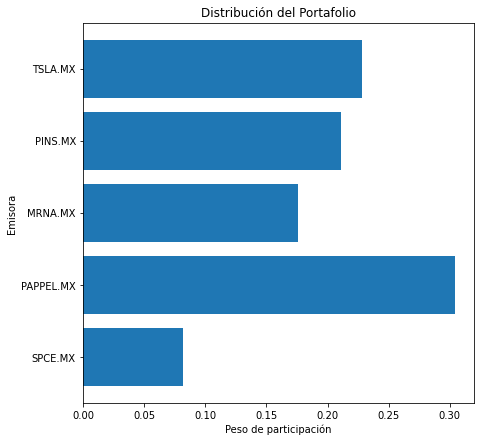

Entrenando Modelo...
Tendencia bajista no se invierte en el portafolio de inversión
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('PAPPEL.MX', 0.3110706656331542), ('SPCE.MX', 0.08108188988919847), ('PINS.MX', 0.20953765586996403), ('MRNA.MX', 0.16867480208981497), ('TSLA.MX', 0.22963498651786834)]


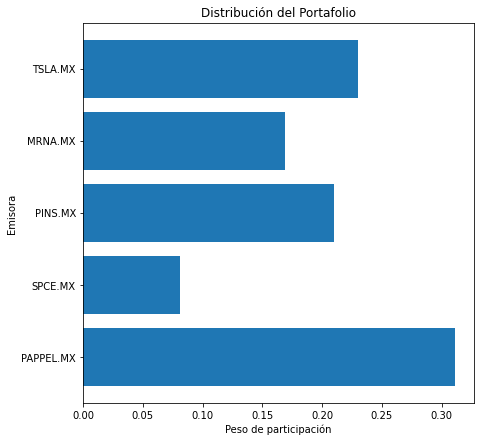

Entrenando Modelo...
Tendencia alcista se invierte en el portafolio de inversión
Evaluación
Días de Inversión 39 	Inversión actual $103936.48980648967
Evaluación
Días de Inversión 40 	Inversión actual $103936.48980648967
Evaluación
Días de Inversión 43 	Inversión actual $105173.49085992044
Evaluación
Días de Inversión 44 	Inversión actual $103255.11964789222
Evaluación
Días de Inversión 45 	Inversión actual $104646.17408811973
Evaluación
Días de Inversión 46 	Inversión actual $106050.92607262915
Evaluación
Días de Inversión 47 	Inversión actual $106050.92607262915
Evaluación
Días de Inversión 50 	Inversión actual $111916.792409043
Evaluación
Días de Inversión 51 	Inversión actual $112538.3560720275
Evaluación
Días de Inversión 52 	Inversión actual $111854.1286708301
Evaluación
Días de Inversión 53 	Inversión actual $114019.93041606667
Evaluación
Días de Inversión 54 	Inversión actual $114019.93041606667
Evaluación
Tendencia bajista se actualiza el portafolio de inversión
Días de Invers

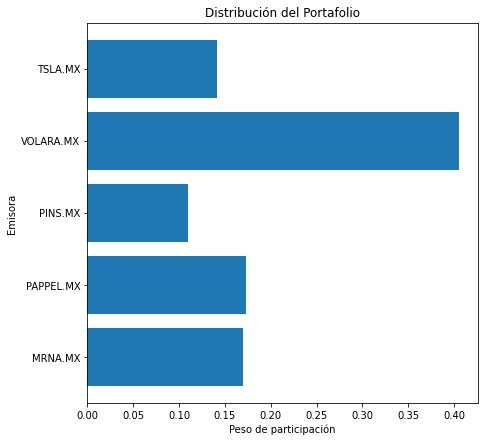

Entrenando Modelo...
Tendencia bajista no se invierte en el portafolio de inversión
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('MRNA.MX', 0.16985016557156446), ('PAPPEL.MX', 0.17561196389644373), ('PINS.MX', 0.10473658613858462), ('VOLARA.MX', 0.4087532268533645), ('TSLA.MX', 0.14104805754004254)]


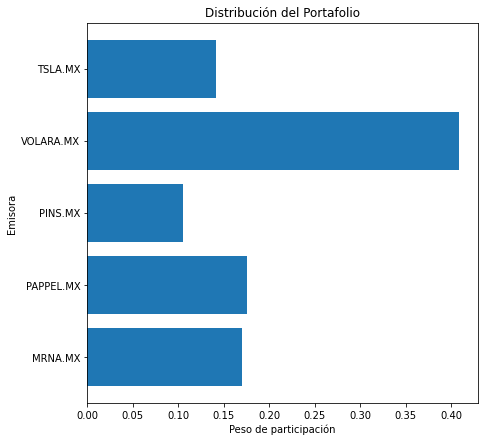

Entrenando Modelo...
Tendencia alcista se invierte en el portafolio de inversión
Evaluación
Días de Inversión 59 	Inversión actual $112982.4332258135
Evaluación
Días de Inversión 60 	Inversión actual $113442.16738412691
	 Portafolio de Inversión con Ventana de Tiempo 10 días
Cargando Datos...
Datos Listos!
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('SPCE.MX', 0.06085129501169284), ('BYND.MX', 5.146711535319591e-17), ('F.MX', 0.6607051735699182), ('INO.MX', 0.0), ('MRNA.MX', 0.27844353141838907)]


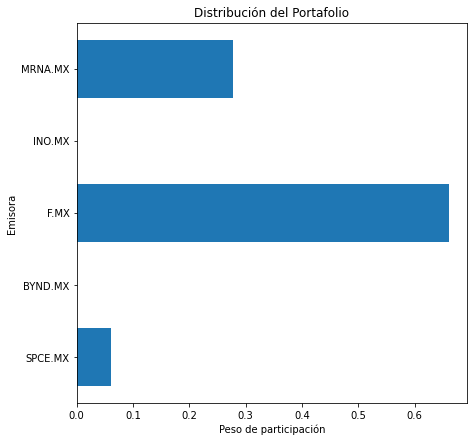

Entrenando Modelo...
Tendencia alcista se invierte en el portafolio de inversión
Evaluación
Tendencia bajista se actualiza el portafolio de inversión
Días de Inversión 1 	Inversión actual $95120.52003275824
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('SPCE.MX', 0.061627215397360845), ('BYND.MX', 6.849447224677174e-16), ('F.MX', 0.560566187610455), ('NVDA.MX', 0.37575589760202405), ('INO.MX', 0.00205069939015942)]


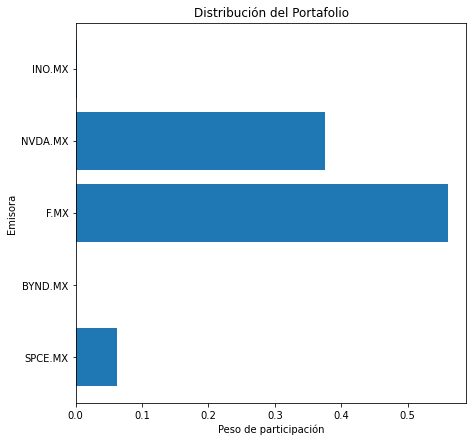

Entrenando Modelo...
Tendencia bajista no se invierte en el portafolio de inversión
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('SPCE.MX', 0.0527420056965158), ('BYND.MX', 2.762347041865386e-17), ('F.MX', 0.6722507529291262), ('FPLUS16.MX', 3.1598823165975476e-17), ('MRNA.MX', 0.2750072413743581)]


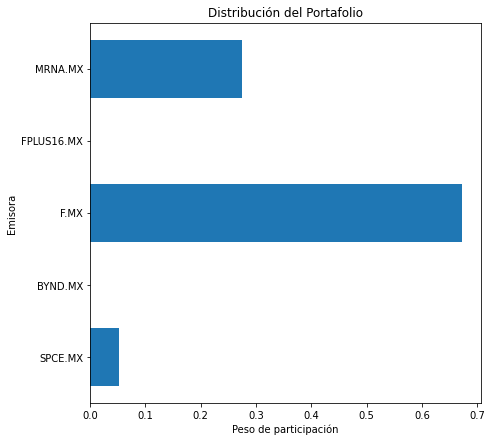

Entrenando Modelo...
Tendencia alcista se invierte en el portafolio de inversión
Evaluación
Días de Inversión 3 	Inversión actual $96816.26791936294
Evaluación
Días de Inversión 4 	Inversión actual $94547.13591284827
Evaluación
Días de Inversión 5 	Inversión actual $94547.13591284827
Evaluación
Días de Inversión 8 	Inversión actual $112811.5106143088
Evaluación
Tendencia bajista se actualiza el portafolio de inversión
Días de Inversión 9 	Inversión actual $106261.83216012066
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('SPORTS.MX', 1.9132988344716627e-17), ('SPCE.MX', 0.29799371365958505), ('FINN13.MX', 3.032196045323372e-17), ('BYND.MX', 1.1429102093341929e-17), ('MRNA.MX', 0.7020062863404148)]


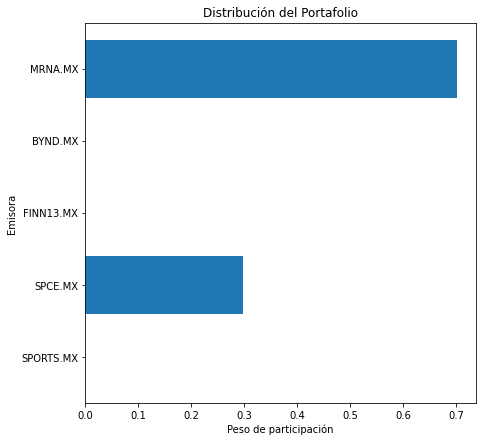

Entrenando Modelo...
Tendencia alcista se invierte en el portafolio de inversión
Evaluación
Días de Inversión 10 	Inversión actual $104855.45109905317
Evaluación
Días de Inversión 11 	Inversión actual $106508.80915327085
Evaluación
Días de Inversión 12 	Inversión actual $106508.80915327085
Evaluación
Tendencia bajista se actualiza el portafolio de inversión
Días de Inversión 15 	Inversión actual $101856.3397012472
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('SPORTS.MX', 6.63786964022562e-17), ('FINN13.MX', 0.0), ('AXTELCPO.MX', 0.5070429407217177), ('SPCE.MX', 0.15539685556489735), ('MRNA.MX', 0.33756020371338497)]


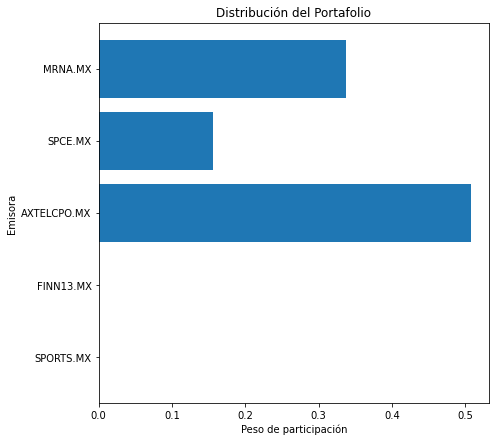

Entrenando Modelo...
Tendencia alcista se invierte en el portafolio de inversión
Evaluación
Días de Inversión 16 	Inversión actual $99368.67023773075
Evaluación
Días de Inversión 17 	Inversión actual $101856.33970124718
Evaluación
Días de Inversión 18 	Inversión actual $103652.99316438231
Evaluación
Días de Inversión 19 	Inversión actual $103652.99316438231
Evaluación
Días de Inversión 22 	Inversión actual $99368.67023773075
Evaluación
Días de Inversión 23 	Inversión actual $96742.79362009015
Evaluación
Días de Inversión 24 	Inversión actual $98124.83221093261
Evaluación
Días de Inversión 25 	Inversión actual $99230.46308360658
Evaluación
Días de Inversión 26 	Inversión actual $99230.46308360658
Evaluación
Días de Inversión 29 	Inversión actual $96466.38590192165
Evaluación
Días de Inversión 30 	Inversión actual $96604.586465966
Evaluación
Días de Inversión 31 	Inversión actual $97986.63164688829
Evaluación
Días de Inversión 32 	Inversión actual $98815.85480139378
Evaluación
Días de In

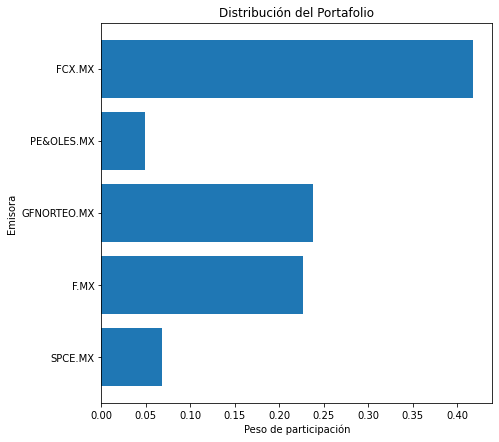

Entrenando Modelo...
Tendencia alcista se invierte en el portafolio de inversión
Evaluación
Días de Inversión 1 	Inversión actual $101314.71856527304
Evaluación
Días de Inversión 2 	Inversión actual $101667.79844919054
Evaluación
Días de Inversión 3 	Inversión actual $101563.33584411645
Evaluación
Días de Inversión 4 	Inversión actual $100593.3519658564
Evaluación
Días de Inversión 5 	Inversión actual $100593.3519658564
Evaluación
Días de Inversión 8 	Inversión actual $101122.55689883725
Evaluación
Tendencia bajista se actualiza el portafolio de inversión
Días de Inversión 9 	Inversión actual $98964.98663081128
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('SPCE.MX', 0.08110090183687767), ('SPORTS.MX', 0.0), ('BYND.MX', 1.7780915628762273e-17), ('F.MX', 0.6370067372963343), ('MRNA.MX', 0.28189236086678804)]


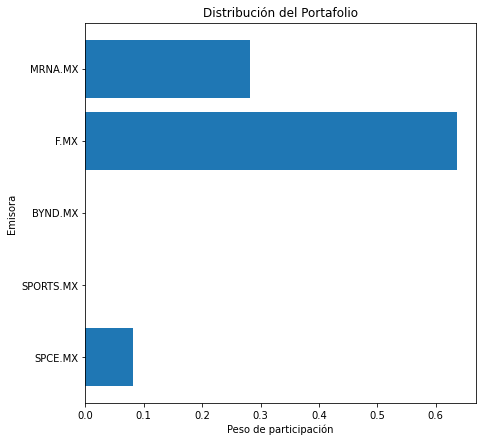

Entrenando Modelo...
Tendencia bajista no se invierte en el portafolio de inversión
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('SPCE.MX', 0.2751017322167387), ('SPORTS.MX', 1.8648277366750676e-17), ('INO.MX', 0.0), ('BYND.MX', 0.0), ('MRNA.MX', 0.7248982677832613)]


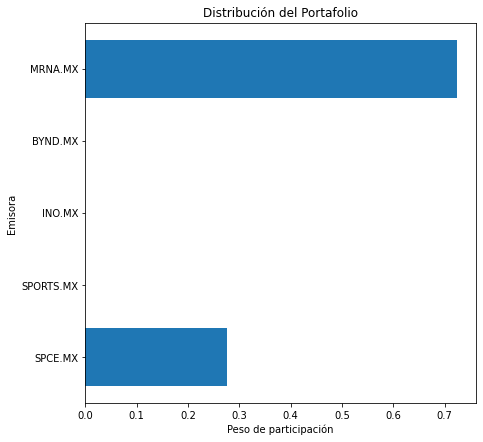

Entrenando Modelo...
Tendencia alcista se invierte en el portafolio de inversión
Evaluación
Días de Inversión 11 	Inversión actual $97975.33676450317
Evaluación
Días de Inversión 12 	Inversión actual $97975.33676450317
Evaluación
Tendencia bajista se actualiza el portafolio de inversión
Días de Inversión 15 	Inversión actual $99389.12228780048
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('SPCE.MX', 0.30024447477297816), ('BYND.MX', 0.0), ('SPORTS.MX', 2.862293735361732e-17), ('INO.MX', 6.071532165918825e-18), ('MRNA.MX', 0.6997555252270219)]


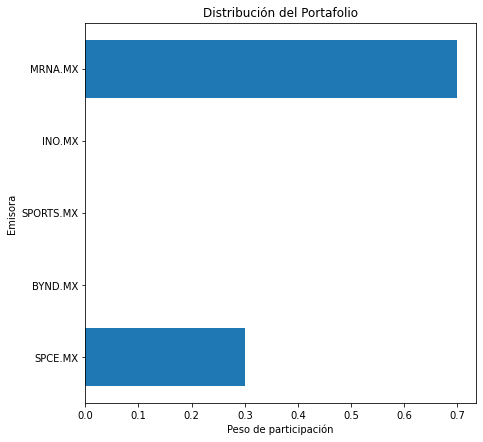

Entrenando Modelo...
Tendencia bajista no se invierte en el portafolio de inversión
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('SPCE.MX', 0.2961608577189621), ('BYND.MX', 0.0), ('SPORTS.MX', 3.881443777498106e-17), ('FINN13.MX', 0.0), ('MRNA.MX', 0.703839142281038)]


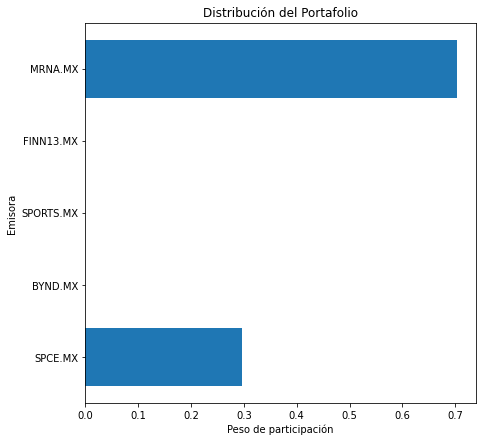

Entrenando Modelo...
Tendencia alcista se invierte en el portafolio de inversión
Evaluación
Días de Inversión 17 	Inversión actual $104400.33571934336
Evaluación
Días de Inversión 18 	Inversión actual $102602.17361633526
Evaluación
Días de Inversión 19 	Inversión actual $102602.17361633526
Evaluación
Días de Inversión 22 	Inversión actual $109853.88124891715
Evaluación
Días de Inversión 23 	Inversión actual $113499.64784896806
Evaluación
Tendencia bajista se actualiza el portafolio de inversión
Días de Inversión 24 	Inversión actual $109884.09837425225
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('SPCE.MX', 0.32224257783998494), ('SPORTS.MX', 0.0), ('FINN13.MX', 1.3552527156068805e-18), ('MRNA.MX', 0.6777574221600151), ('INO.MX', 1.485356976305141e-17)]


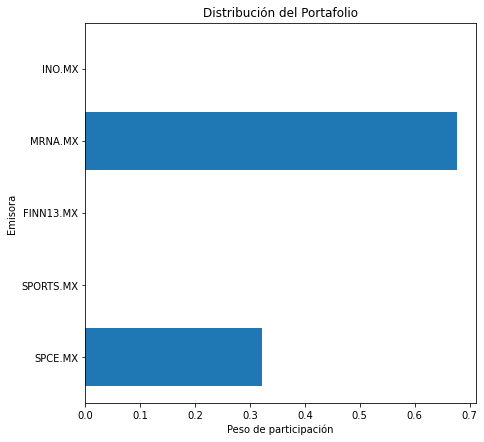

Entrenando Modelo...
Tendencia bajista no se invierte en el portafolio de inversión
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('SPORTS.MX', 2.988011078005141e-17), ('FINN13.MX', 5.745039550398437e-17), ('SPCE.MX', 0.16511825386998566), ('AZTECACPO.MX', 0.5003699031277589), ('MRNA.MX', 0.3345118430022555)]


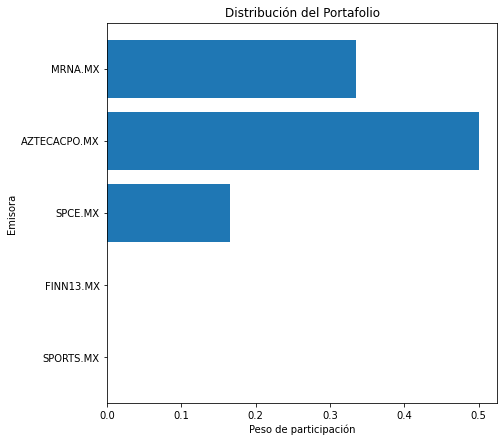

Entrenando Modelo...
Tendencia alcista se invierte en el portafolio de inversión
Evaluación
Días de Inversión 26 	Inversión actual $109884.09837425224
Evaluación
Días de Inversión 29 	Inversión actual $112321.40119890803
Evaluación
Días de Inversión 30 	Inversión actual $112602.37334871595
Evaluación
Días de Inversión 31 	Inversión actual $112258.49377047716
Evaluación
Días de Inversión 32 	Inversión actual $110835.0176447303
Evaluación
Días de Inversión 33 	Inversión actual $110835.0176447303
Evaluación
Días de Inversión 36 	Inversión actual $113155.69275756337
Evaluación
Días de Inversión 37 	Inversión actual $107377.51076049024
Evaluación
Días de Inversión 38 	Inversión actual $114645.21732834878
Evaluación
Días de Inversión 39 	Inversión actual $112227.11585971659
Evaluación
Días de Inversión 40 	Inversión actual $112227.11585971659
Evaluación
Días de Inversión 43 	Inversión actual $110748.76691897819
Evaluación
Días de Inversión 44 	Inversión actual $111950.06044291261
Evaluación


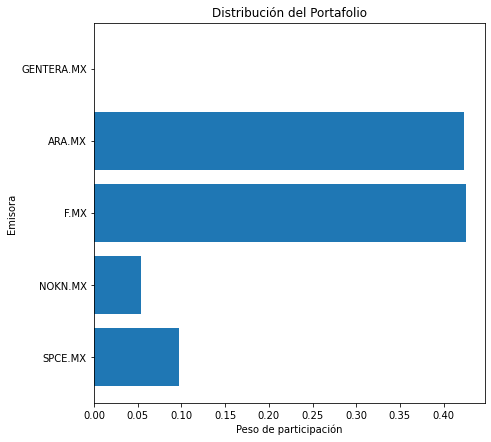

Entrenando Modelo...
Tendencia alcista se invierte en el portafolio de inversión
Evaluación
Tendencia bajista se actualiza el portafolio de inversión
Días de Inversión 1 	Inversión actual $96827.30824289538
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('SPCE.MX', 0.08480915387128724), ('NOKN.MX', 0.032167219551109974), ('F.MX', 0.28384954885857866), ('BBAJIOO.MX', 0.2964576366854775), ('ARA.MX', 0.3027164410335465)]


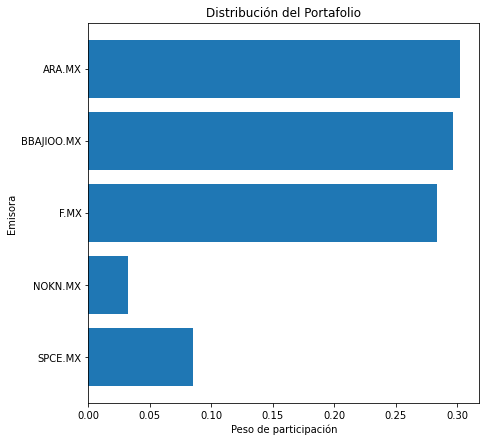

Entrenando Modelo...
Tendencia bajista no se invierte en el portafolio de inversión
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('SPCE.MX', 0.09485756817812761), ('F.MX', 0.64561177342189), ('NOKN.MX', 0.08123409310516502), ('X.MX', 0.17829656529481738), ('NCLHN.MX', 5.0611309042232323e-17)]


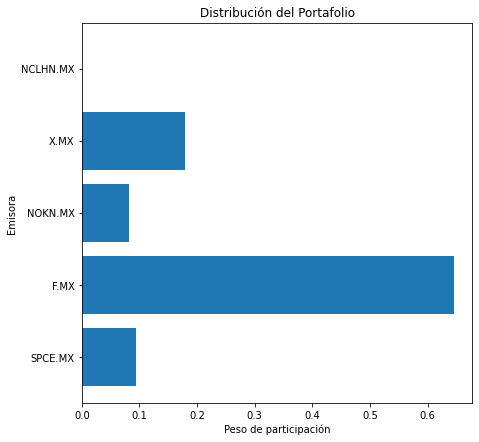

Entrenando Modelo...
Tendencia alcista se invierte en el portafolio de inversión
Evaluación
Días de Inversión 3 	Inversión actual $98392.5504594904
Evaluación
Días de Inversión 4 	Inversión actual $97148.71600701315
Evaluación
Días de Inversión 5 	Inversión actual $97148.71600701315
Evaluación
Días de Inversión 8 	Inversión actual $99182.34175708628
Evaluación
Días de Inversión 9 	Inversión actual $98159.36089362194
Evaluación
Días de Inversión 10 	Inversión actual $97860.16818766769
Evaluación
Días de Inversión 11 	Inversión actual $99499.74799940294
Evaluación
Días de Inversión 12 	Inversión actual $99499.74799940294
Evaluación
Días de Inversión 15 	Inversión actual $96165.88436103304
Evaluación
Días de Inversión 16 	Inversión actual $97347.87144730035
Evaluación
Tendencia bajista se actualiza el portafolio de inversión
Días de Inversión 17 	Inversión actual $94785.29341782694
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de invers

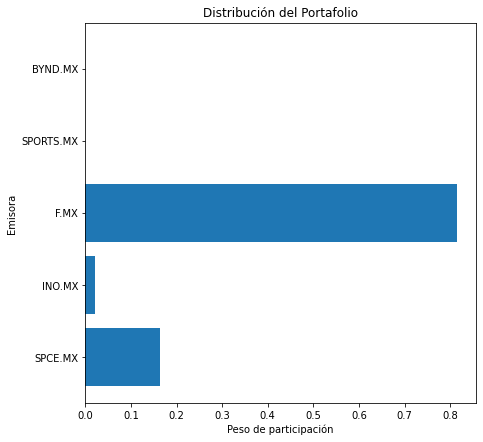

Entrenando Modelo...
Tendencia alcista se invierte en el portafolio de inversión
Evaluación
Tendencia bajista se actualiza el portafolio de inversión
Días de Inversión 18 	Inversión actual $93051.85488300495
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('SPCE.MX', 0.21112461601010707), ('INO.MX', 7.623296525288703e-17), ('BYND.MX', 0.0), ('NVDA.MX', 0.7556813471793423), ('ZM.MX', 0.033194036810550845)]


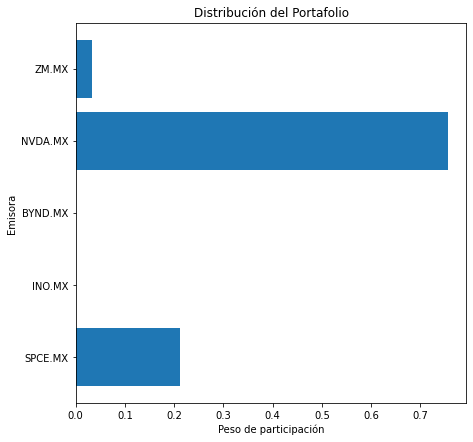

Entrenando Modelo...
Tendencia alcista se invierte en el portafolio de inversión
Evaluación
Días de Inversión 19 	Inversión actual $93051.85488300495
Evaluación
Días de Inversión 22 	Inversión actual $99628.56590673275
Evaluación
Días de Inversión 23 	Inversión actual $102934.98069940366
Evaluación
Tendencia bajista se actualiza el portafolio de inversión
Días de Inversión 24 	Inversión actual $99655.97039011316
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('SPCE.MX', 0.15321632762731677), ('INO.MX', 2.358139725155972e-16), ('BYND.MX', 0.0), ('MRNA.MX', 0.3047410703917875), ('NVDA.MX', 0.5420426019808959)]


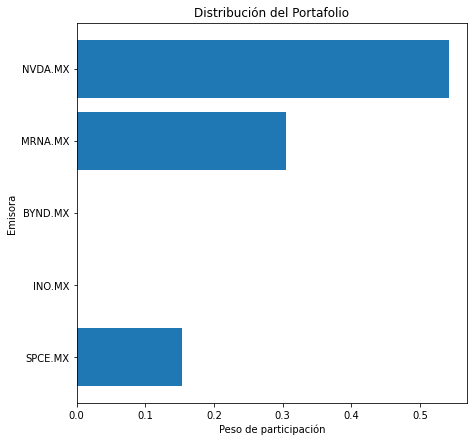

Entrenando Modelo...
Tendencia bajista no se invierte en el portafolio de inversión
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('SPCE.MX', 0.14895670199437322), ('MRNA.MX', 0.3171710883250645), ('BYND.MX', 0.0), ('INO.MX', 2.602229015625915e-17), ('NVDA.MX', 0.5338722096805624)]


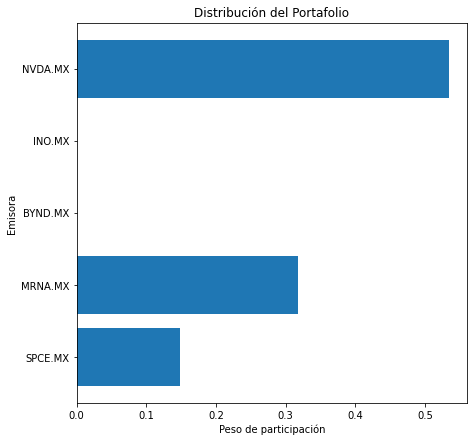

Entrenando Modelo...
Tendencia alcista se invierte en el portafolio de inversión
Evaluación
Días de Inversión 26 	Inversión actual $99655.97039011316
Evaluación
Días de Inversión 29 	Inversión actual $104671.85000684264
Evaluación
Días de Inversión 30 	Inversión actual $105313.9750523459
Evaluación
Días de Inversión 31 	Inversión actual $105025.67612274535
Evaluación
Días de Inversión 32 	Inversión actual $103757.52365489198
Evaluación
Días de Inversión 33 	Inversión actual $103757.52365489198
Evaluación
Días de Inversión 36 	Inversión actual $104830.94545401154
Evaluación
Tendencia bajista se actualiza el portafolio de inversión
Días de Inversión 37 	Inversión actual $100957.60170583206
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('SPCE.MX', 0.15118685744717655), ('AZTECACPO.MX', 0.5394411215697673), ('SPORTS.MX', 0.0), ('MRNA.MX', 0.3093720209830563), ('FINN13.MX', 0.0)]


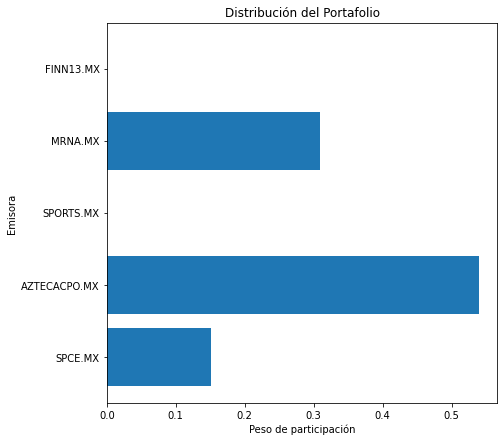

Entrenando Modelo...
Tendencia bajista no se invierte en el portafolio de inversión
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('SPCE.MX', 0.13098228641974402), ('AZTECACPO.MX', 0.41292537292868625), ('SPORTS.MX', 4.725088592963389e-17), ('FINN13.MX', 4.960224939121183e-18), ('NVDA.MX', 0.4560923406515695)]


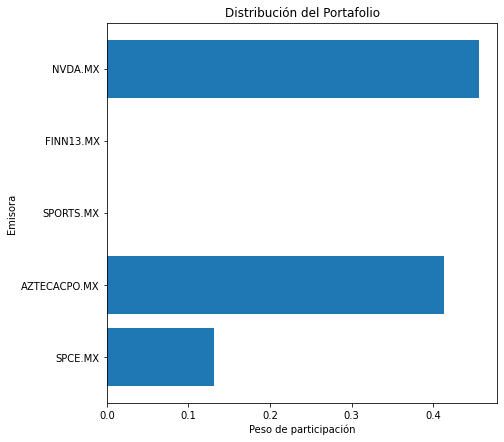

Entrenando Modelo...
Tendencia alcista se invierte en el portafolio de inversión
Evaluación
Días de Inversión 39 	Inversión actual $101155.62543860494
Evaluación
Días de Inversión 40 	Inversión actual $101155.62543860494
Evaluación
Días de Inversión 43 	Inversión actual $101312.67439430986
Evaluación
Tendencia bajista se actualiza el portafolio de inversión
Días de Inversión 44 	Inversión actual $97601.33455652927
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('HOMEX.MX', 4.53138405359295e-18), ('SPCE.MX', 0.2541932980235942), ('AZTECACPO.MX', 0.7458067019764059), ('FINN13.MX', 1.1748114379959757e-17), ('SPORTS.MX', 1.7761765127998947e-17)]


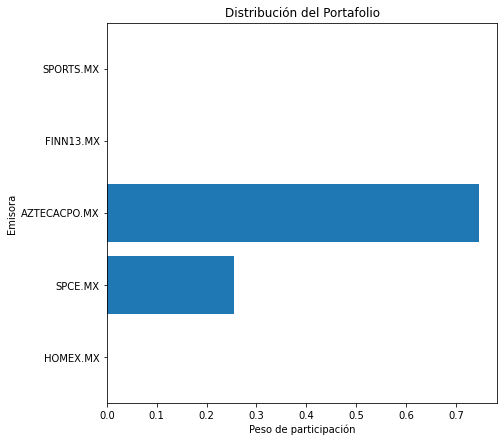

Entrenando Modelo...
Tendencia bajista no se invierte en el portafolio de inversión
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('HOMEX.MX', 0.0), ('AZTECACPO.MX', 0.2287729526714767), ('MRNA.MX', 0.2342377945178644), ('VOLARA.MX', 0.536989252810659), ('AEROMEX.MX', 2.5484774928430582e-17)]


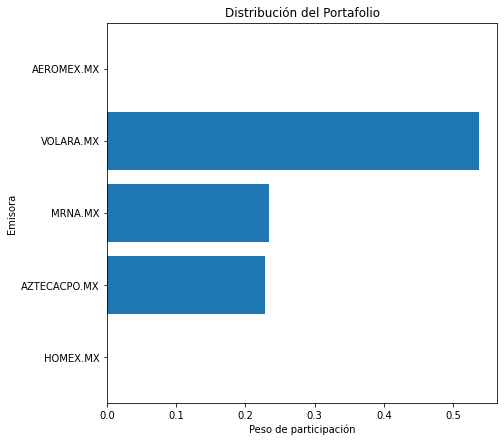

Entrenando Modelo...
Tendencia alcista se invierte en el portafolio de inversión
Evaluación
Días de Inversión 46 	Inversión actual $106506.63045296127
Evaluación
Días de Inversión 47 	Inversión actual $106506.63045296127
Evaluación
Días de Inversión 50 	Inversión actual $117616.11645724473
Evaluación
Días de Inversión 51 	Inversión actual $120787.46710054611
Evaluación
Días de Inversión 52 	Inversión actual $121216.38227962876
Evaluación
Días de Inversión 53 	Inversión actual $130293.99141749654
Evaluación
Días de Inversión 54 	Inversión actual $130293.99141749654
Evaluación
Tendencia bajista se actualiza el portafolio de inversión
Días de Inversión 57 	Inversión actual $122364.17696704378
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('HOMEX.MX', 0.0), ('MRNA.MX', 0.2042906995576203), ('AZTECACPO.MX', 0.1999315728581845), ('NKE.MX', 0.21401353062327924), ('VOLARA.MX', 0.381764196960916)]


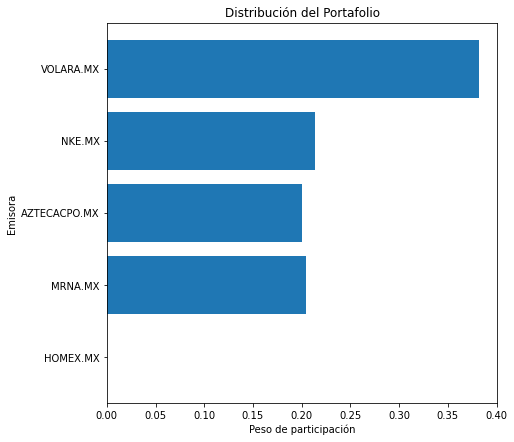

Entrenando Modelo...
Tendencia bajista no se invierte en el portafolio de inversión
Creando un portafolio de inversión con 5 emisoras
Actualizando Precios...
Datos listos!
Portafolio de inversión creado
[('HOMEX.MX', 3.280145223968321e-17), ('MRNA.MX', 0.20385117508813738), ('AZTECACPO.MX', 0.19942829851045707), ('NKE.MX', 0.21265571612726455), ('VOLARA.MX', 0.3840648102741409)]


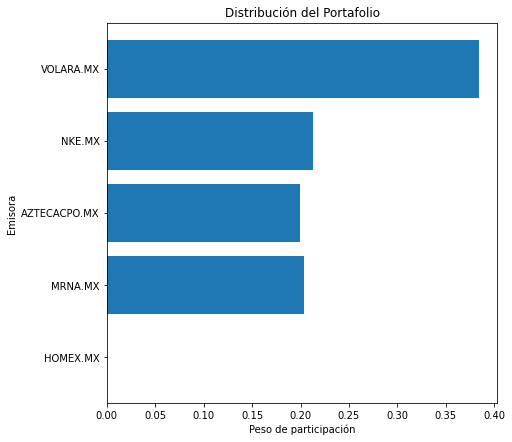

Entrenando Modelo...
Tendencia alcista se invierte en el portafolio de inversión
Evaluación
Días de Inversión 59 	Inversión actual $121523.54403394966
Evaluación
Días de Inversión 60 	Inversión actual $124298.50504884205


{'10 Días': ([100000,
   100000,
   95120.52003275824,
   95120.52003275824,
   95120.52003275824,
   96816.26791936294,
   94547.13591284827,
   94547.13591284827,
   112811.5106143088,
   106261.83216012066,
   106261.83216012066,
   104855.45109905317,
   106508.80915327085,
   106508.80915327085,
   101856.3397012472,
   101856.3397012472,
   99368.67023773075,
   101856.33970124718,
   103652.99316438231,
   103652.99316438231,
   99368.67023773075,
   96742.79362009015,
   98124.83221093261,
   99230.46308360658,
   99230.46308360658,
   96466.38590192165,
   96604.586465966,
   97986.63164688829,
   98815.85480139378,
   98815.85480139378,
   100197.89339223623,
   100888.91598269735,
   99230.46308360658,
   99506.8708017751,
   99506.8708017751,
   98124.83221093261,
   98124.83221093261,
   98677.64764726961,
   102270.95457353986,
   102270.95457353986,
   99092.26251956225,
   98954.0553654381,
   99092.26251956225,
   99092.26251956225,
   99092.26251956225,
   97433.81621

In [6]:
portafolio={}
ventana_tiempo= [0,10,20,30]
for i in ventana_tiempo:
  if i==0:
    print(f'\t Portafolio de Inversión Total')
    portafolio['Total']=administrador(tam_port=5,tiempo=60)
  else:
    print(f'\t Portafolio de Inversión con Ventana de Tiempo {i} días')
    portafolio[f'{i} Días']=administrador(tam_port=5,tiempo=60,ventana=True,tam_vent=i)

portafolio

Gráficas de tendencia del monto invertido en los distintos portafolio de inversión creados por el Administrador de portafolios.

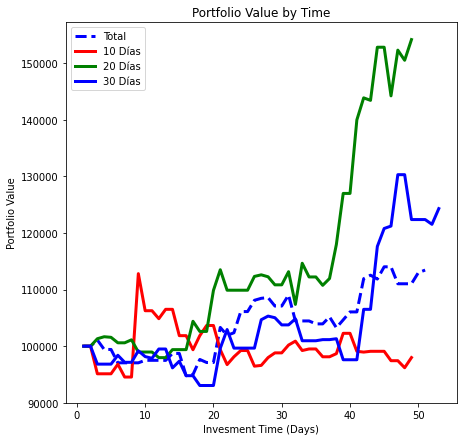

In [9]:
key=portafolio.keys()
indice=0
color=['red','green','blue','orange','gray','cyan','brown','purple','olive','pink'] #Paleta de colores 
 
plt.figure(figsize=(7,7))
for k in key:
  if k=='Total':
    #print(portafolio[k][0])
    plt.plot(range(1,len(portafolio[k][0])+1),portafolio[k][0],linewidth=3,color='blue',label='Total',linestyle='dashed')
  else:
    plt.plot(range(1,len(portafolio[k][0])+1),portafolio[k][0],linewidth=3,label=k,color=color[indice%10])
    indice+=1
#plt.xlabel('Días de inversión')
#plt.ylabel('Valor del Portafolio')
#plt.title('Valor del Portafolio')
#Inglés
plt.xlabel('Invesment Time (Days)')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value by Time')
plt.legend()
plt.show()


Especificación del modelo diseñado para la toma de decisión dentro del Administrador del Portafolio.

In [10]:
#complemento=precios(['AC.MX', 'ACTINVRB.MX','AEROMEX.MX','AGUA.MX','ALFAA.MX'],fecha_inicio,fecha_final)
red=load_model('decision_cnn.h5')
red.summary()


Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_68 (Conv1D)           (None, 14, 64)            128       
_________________________________________________________________
max_pooling1d_68 (MaxPooling (None, 7, 64)             0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 7, 64)             0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 7, 64)             4160      
_________________________________________________________________
max_pooling1d_69 (MaxPooling (None, 3, 64)             0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 192)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)               

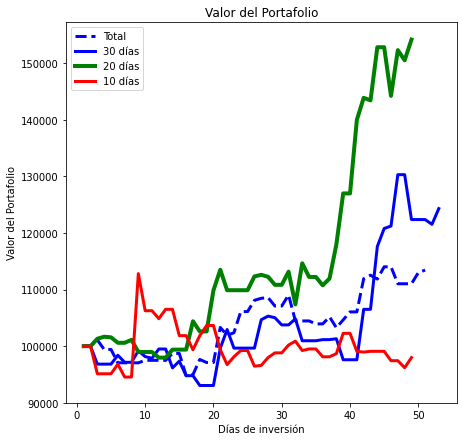

In [11]:
inversiont=portafolio['Total'][0]
inversion10=portafolio['10 Días'][0]
inversion20=portafolio['20 Días'][0]
inversion30=portafolio['30 Días'][0]

#print(periodo)
plt.figure(figsize=(7,7))
plt.plot(range(1,len(inversiont)+1),inversiont,linewidth=3,color='blue',label='Total',linestyle='dashed')
plt.plot(range(1,len(inversion30)+1),inversion30,linewidth=3,color='blue',label='30 días')
plt.plot(range(1,len(inversion20)+1),inversion20,linewidth=4,color='green',label='20 días')
plt.plot(range(1,len(inversion10)+1),inversion10,linewidth=3,color='red',label='10 días')
plt.xlabel('Días de inversión')
plt.ylabel('Valor del Portafolio')
plt.title('Valor del Portafolio')
#Inglés
#plt.xlabel('Invesment Time (Days)')
#plt.ylabel('Portfolio Value')
#plt.title('Portfolio Value by Time')
plt.legend()
plt.show()
